In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O ~/tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O ~/tmp/rps-test-set.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-validation.zip \
    -O ~/tmp/rps-validation.zip


--2020-02-03 17:06:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response...200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/home/lee/tmp/rps.zip’

/home/lee/tmp/rps.z 100%[===================>] 191.38M  6.35MB/s    in 31s     

2020-02-03 17:06:46 (6.18 MB/s) - ‘/home/lee/tmp/rps.zip’ saved [200682221/200682221]

--2020-02-03 17:06:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response...200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/home/lee

In [7]:
import os
import zipfile

tmp_dir = os.path.expanduser('~/tmp')
try: 
    os.mkdir(tmp_dir)
except: 
    pass

local_zip = os.path.join(tmp_dir, 'rps.zip')
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(tmp_dir)
zip_ref.close()

local_zip = os.path.join(tmp_dir, 'rps-test-set.zip')
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(tmp_dir)
zip_ref.close()

output_dir = os.path.join(tmp_dir, 'rps-test')
try: 
    os.mkdir(output_dir)
except: 
    pass
local_zip = os.path.join(tmp_dir, 'rps-validation.zip')
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(output_dir)
zip_ref.close()


In [13]:
rock_dir = os.path.join(tmp_dir, 'rps', 'rock')
print(rock_dir)
paper_dir = os.path.join(tmp_dir, 'rps', 'paper')
scissors_dir = os.path.join(tmp_dir, 'rps', 'scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
paper_files = os.listdir(paper_dir)
scissors_files = os.listdir(scissors_dir)


/home/lee/tmp/rps/rock
total training rock images: 840
total training paper images: 840
total training scissors images: 840


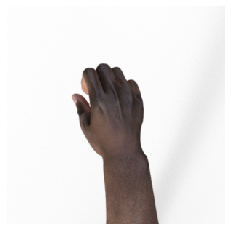

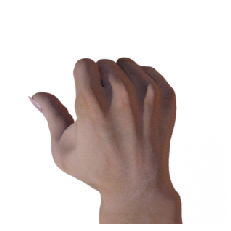

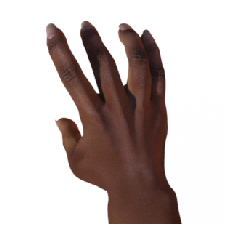

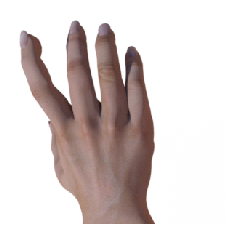

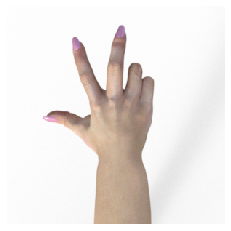

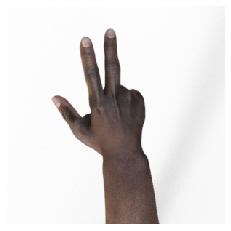

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [16]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import os

TRAINING_DIR = os.path.expanduser('~/tmp/rps')
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = os.path.expanduser('~/tmp/rps-test-set/')
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit_generator(train_generator, epochs=25, validation_data = validation_generator, verbose = 1)

model.save("rps.h5")


Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_______________________________________

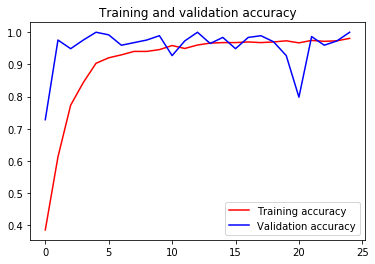

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [25]:
import numpy as np
import os
from tensorflow.keras.preprocessing import image

upload_path = os.path.expanduser('~/tmp/rps-test')
uploaded = os.listdir(upload_path)

c = None
incorrect_images = []

for fn in uploaded:
 
  # predicting images
  img = image.load_img(os.path.join(upload_path, fn), target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  c = classes[0]
  category = ['paper', 'rock', 'scissors'][np.where(c == np.amax(c))[0][0]]
  
  if fn.find(category) == -1:
    incorrect_images.append(fn)

  print(fn, ' =>', category, '\tclasses=', c)

print(incorrect_images)


rock8.png  => rock 	classes= [0. 1. 0.]
paper2.png  => paper 	classes= [1. 0. 0.]
scissors1.png  => scissors 	classes= [0. 0. 1.]
scissors8.png  => scissors 	classes= [0. 0. 1.]
rock1.png  => rock 	classes= [0. 1. 0.]
rock5.png  => rock 	classes= [0. 1. 0.]
paper3.png  => scissors 	classes= [0. 0. 1.]
paper5.png  => paper 	classes= [1. 0. 0.]
scissors2.png  => scissors 	classes= [0. 0. 1.]
paper7.png  => paper 	classes= [1. 0. 0.]
scissors6.png  => scissors 	classes= [0. 0. 1.]
scissors9.png  => scissors 	classes= [0. 0. 1.]
paper1.png  => paper 	classes= [1. 0. 0.]
scissors-hires1.png  => scissors 	classes= [0. 0. 1.]
paper-hires2.png  => paper 	classes= [1. 0. 0.]
scissors7.png  => scissors 	classes= [0. 0. 1.]
rock7.png  => rock 	classes= [0. 1. 0.]
paper-hires1.png  => paper 	classes= [1. 0. 0.]
paper4.png  => paper 	classes= [1. 0. 0.]
rock-hires2.png  => rock 	classes= [0. 1. 0.]
scissors-hires2.png  => scissors 	classes= [0. 0. 1.]
scissors5.png  => scissors 	classes= [0. 0. 1.]

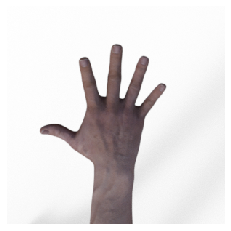

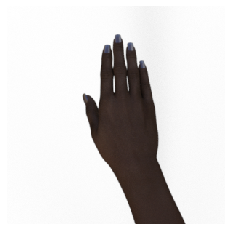

In [30]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for img_path in incorrect_images:
  #print(img_path)
  img = mpimg.imread(os.path.join(os.path.expanduser('~/tmp/rps-test'), img_path))
  plt.imshow(img)
  plt.axis('Off')
  plt.show()